# Scientific computing
___

**Gregory Farage, Śaunak Sen**    

    gfarage@uthsc.edu / sen@uthsc.edu
    Division of Biostatistics
    Department of Preventive Medicine
    University of Tennessee Health Science Center
    Memphis, TN



In this note we will look at some Julia features for scientific computing including linear algebra, the typing system, and parallel/distributed computing.

## Example: Least squares

We will write a simple linear regression routine that will use linear algebra functions.  Recall that we want to fit a model of the form

$$ y = X\beta + \epsilon,$$ 

where $y$ is the response vector, $X$ is the matrix of predictors (design matrix) and $\epsilon$ are the errors.  We assume homoscedastic error, so that $V(\epsilon) = \sigma^2 I$.

In [1]:
# load packages we will be using
using LinearAlgebra, DataFrames, CSV, GLM, BenchmarkTools

We download the Arabidopsis data from the web URL.

In [2]:
agrenURL = agrenURL = "https://raw.githubusercontent.com/sens/smalldata/master/arabidopsis/agren2013.csv"
agren = CSV.read(download(agrenURL),DataFrame,missingstring="NA");

For convenience we subset the data to those without any missing data.  We will also convert the data frame into a matrix so that the linear regression routine does not have to handle missing data.

In [3]:
# drop the rows with missing data
agren1 = dropmissing(agren)
# check how many rows are left
nrow(agren1)
# few rows
first(agren1,4)

Row,it09,it10,it11,sw09,sw10,sw11,id,flc
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,19.7616,24.1761,15.6778,5.66443,21.4804,4.47778,1,1
2,6.28846,1.77401,3.23889,9.54305,22.1222,7.76667,2,2
3,12.034,12.4605,10.601,11.8038,23.0487,14.8712,3,2
4,20.1253,14.1169,12.9035,7.44263,22.5834,8.1937,6,1


Next, we conver the data into a matrix (from a data frame); we will do the linear regression of fitness in Italy for 2010 using the 2009 data as the predictor.

In [4]:
# convert data frame to matrix
agrenMat = Matrix(agren1[:,1:6])
# convert outcome/response vector to a matrix with one column
y = reshape(agrenMat[:,2],:,1)
# make the predictor matrix including an intercept
X = [ ones(nrow(agren1)) agrenMat[:,1] ]

392×2 Matrix{Float64}:
 1.0  19.7616
 1.0   6.28846
 1.0  12.034
 1.0  20.1253
 1.0  15.1278
 1.0  19.2091
 1.0  12.9434
 1.0  14.2244
 1.0  20.5921
 1.0  15.6141
 1.0  10.9073
 1.0  11.8156
 1.0  13.0657
 ⋮    
 1.0  12.8839
 1.0  10.4514
 1.0  12.6483
 1.0   9.6031
 1.0   9.4072
 1.0  15.6564
 1.0   8.98307
 1.0  12.1569
 1.0   9.39266
 1.0  11.965
 1.0  11.593
 1.0  14.265

We use the standard function to do the linear regression.

In [5]:
# run linear regression using built-in function
# @btime
out = lm(@formula(it10~it09),agren1)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

it10 ~ 1 + it09

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -0.611065   0.660604   -0.93    0.3555  -1.90985    0.687726
it09          0.708875   0.0530086  13.37    <1e-33   0.604656   0.813093
─────────────────────────────────────────────────────────────────────────

We will create a data structure called `Ls` to store the results of linear regression.

In [6]:
# define new data structure (object)
struct Ls
    β::Matrix{Float64} # regression coefficients
    V::Matrix{Float64} # variance covariance of estimates
end

Next we write a function to calculate the least squares estimate and variance-covariance matrix.  Note that we specify the types of the arguments.  This is important for the compiler to optimize for speed.

It is well-known that the least squares estimates have closed-form formulas.
$$\hat{\beta} = (X^\prime X)^{{-}1} X^\prime y,$$
$$\hat{y} = X\hat{\beta}$$
$$\hat{\sigma^2} = \|y-\hat{y}\|^2 /(n-p)$$
$$ V(\hat{\beta}) = \sigma^2 (X^\prime X)^{{-}1}$$

In [7]:
"""
ls: function for least squares estimation

y = response (matrix with one column)
X = matrix of predictors (assumed to be of full rank)
"""
function ls( y::Matrix{Float64}, X::Matrix{Float64} )
    n,p = size(X)   # dimensions of design matrix (predictors)
    β = (X'X)\(X'y) # least squares estimate
    ŷ = X*β      # calculate fitted values
    σ² = norm(y-ŷ)^2/(n-p)  # calculate residual standard deviation
    return Ls(β,(σ²*inv(X'X))) # return estimate and variance/covariance
end;

We now examine the estimates and compare with the values of the standard implementation.

In [8]:
# @btime
lsout = ls(y,X)

Ls([-0.6110646951084405; 0.7088745462882894;;], [0.43639736798916184 -0.03434349111923561; -0.03434349111923561 0.0028099070240469883])

In [9]:
hcat( lsout.β, coef(out) )

2×2 Matrix{Float64}:
 -0.611065  -0.611065
  0.708875   0.708875

We compare the variance covariances as well, which are also essentially identical.

In [10]:
lsout.V

2×2 Matrix{Float64}:
  0.436397   -0.0343435
 -0.0343435   0.00280991

In [11]:
vcov(out)

2×2 Matrix{Float64}:
  0.436397   -0.0343435
 -0.0343435   0.00280991

## Example: Gradient descent

Now we examine writing a simple minimizer using gradient descent for a convex function that is a squared error loss with a L$_1$ penalty.  We import a package to perform symbolic differentiation.

We consider minimizing the with respect to $x$, the function $$f(x) = (x-2)^2 + 2\|x\|.$$

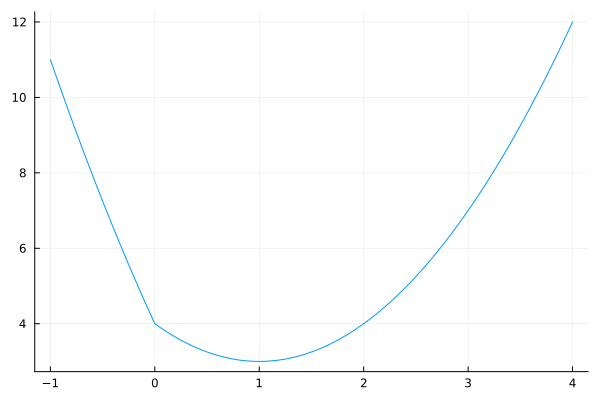

In [12]:
using Calculus, Plots
f(x) = (x-2.0)^2 + 2.0*abs(x)
plot(f,-1,4,lab="")

We calculate the derivative and assign the the function a name.

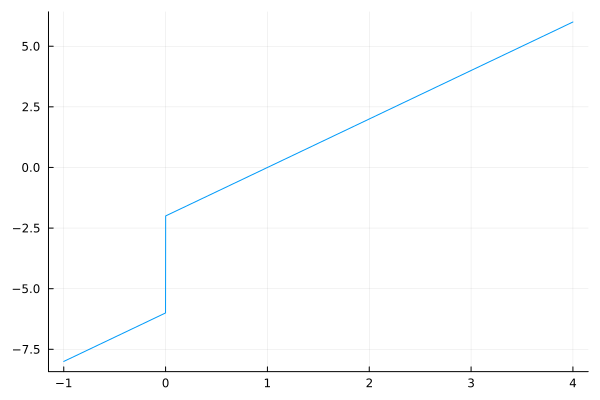

In [13]:
plot(derivative(f),-1,4,lab="")

We write the gradient descent solver that takes as input the function, its gradient, an initial value, a stepsize, and a tolerance value to determine convergence.  The block of text within triple quotes before a function definition is interpreted as Markdown for documenting the function.

The function is very easy to understand, and almost looks like pseudocode.

In [ ]:
"""
gradientDescent: Minimizer of a one-dimensional function using gradient descent

- f = function to minimize (scalar arguments)   
- ∇f = derivative of f   
- x0 = starting value  
- stepsize = step size for gradient descent  
- tol = tolerance for determining convergence
"""
function gradientDescent( f::Function, ∇f::Function, x0::Float64, stepsize::Float64, tol::Float64)
    change = 10.0*tol # initialize change variable
    x1 = x0 # intialize current value
    while( abs(change)>tol ) # repeat loop while convergence criterion unmet
        x1 = x0 - stepsize*∇f(x0) # new value is old value in the direction of the gradient
        change = f(x1)-f(x0) # calculate change
        x0 = x1 # update old value
    end
    return x1, f(x1) # return minimizer and function value
end

In [ ]:
?gradientDescent

Now we are ready to apply this function to the LASSO like function.

In [ ]:
gradientDescent( f , derivative(f), 1.0, 0.5, 1e-5)

In [ ]:
f(0)

## Pass by reference

When dealing with large datasets, it is useful to avoid copying the data too much.  In Julia, arrays are passed by reference, by default.  This may take some getting used to for R or Matlab users, as the following example shows.

We define an array with three values.

In [ ]:
men = ["tom","dick","harry"]

We make a copy called `horsemen`, which is just a copy of the pointer, so is still referring to the same data as `men`.

The variable `footmen` holds a copy of the data into a new array.

In [ ]:
horsemen = men
footmen = copy(men)
hcat( men, horsemen, footmen )

Not let's change the name of the first element of `men`, and see what happens.

In [ ]:
horsemen[1] = "john"
hcat(men,horsemen,footmen)

We see that both `men` and `horsemen` have changed, but `footmen` has not (because it is a copy of the original data).

Not copying data saves a lot of time, as the following timing example shows.

In [ ]:
@time x0 = randn(10000,10000);

In [ ]:
@time x1 = x0; # copy pointer

In [ ]:
@time x2 = copy(x0); # copy data

## Multiple dispatch

The idea of multiple dispatch is that you can have the same function name (to the users), but depending on the type of the argument, a different underlying function will be called.  This has the advantage of presenting a unified interface to the users, and can also be used to create default functions for certain types that work generally over a type.

Consider how we would simulate a 4x4 matrix of random normal variables.

In [ ]:
using Distributions
rand(Normal(),4,4)

The same function is called to simulate a 4x4 matrix of random uniform variables.  The underlying functions are different, but are called with a unified interface.  It also helps us think in more abstract terms. The `rand` function gets random numbers and arranges them into a 4x4 array. Depending on the distribution type, it uses a different random number generation function.

In [ ]:
rand(Uniform(),4,4)

We can look at the type of `Normal()` and its supertype.

In [ ]:
typeof(Normal())

In [ ]:
supertype(Normal)

We can calculate the pdf, calculate the MLE for data.

In [ ]:
pdf(Normal(),0.0)

In [ ]:
fit_mle(Normal,rand(Normal(2.0,3.0),10000))

If we define the `+` operation among distributions to be a convolution, we can even "add" distributions and for distributions that are closed under convolution, this function will work automatically without extra work from us.

In [ ]:
import Base.+

In [ ]:
+(x::Distribution,y::Distribution) = convolve(x,y)

In [ ]:
(Cauchy()+Cauchy()+Cauchy())/3

## Parallel and distributed computing

We write a function for generating a random walk.

In [ ]:
function randomwalk(n::Int64)
    x = rand(Normal(),n)
    return cumsum(x)/sqrt(n)
end

It can take some time to run large random walks.  If we want to run 4 of those, it takes longer than we would like.  Since the 4 walks can be done independently, we can use distributed computing.

In [ ]:
@time randomwalk(10_000_000);

In [ ]:
@time mapreduce(x->randomwalk(10_000_000),hcat,1:4) |> size

We check the hardware.

In [ ]:
using Hwloc
Hwloc.getinfo()

We load the `Distributed` package, check the number of processes running, and add tweo more processes.

In [ ]:
using Distributed

In [ ]:
nprocs()

In [ ]:
addprocs(2)

In [ ]:
workers()

To run on different computers, we have to send the functions everywhere.

In [ ]:
@everywhere using Distributions, Random
@everywhere function randomwalk(n::Int64)
    x = rand(Normal(),n)
    return cumsum(x)/sqrt(n)
end

Compare the time for parallel map to a simple map.

In [ ]:
@time pmap(i->randomwalk(10_000_000),1:10);

In [ ]:
@time map(i->randomwalk(10_000_000),1:10);

For reproducibility we will want more control over the random number generator and send the same seeds to each process as in this example below.

In [ ]:
rng = MersenneTwister.(1:3);

In [ ]:
pmap( r -> rand(r,Normal(),3), rng )

## Exercises

- Find out how many cores and threads you can run on your computer.
- Add at least two processes to your instance.
- Generate 4 Uniform(0,1) random numbers on each thread and return the matrix; call that A
- Calculate A(A'A)⁻¹A' (transpose matrix A, if it is not full rank).